# Training — Exam Reference Sheet Generator

**Best to run it here on Google Colab: https://colab.research.google.com/drive/1cARDH59mQB4LZpH5EnlBDk3MEbqb7Cem#scrollTo=Dg93ejlIAHik**

This notebook trains a FLAN-T5 model to generate exam reference sheets from:
- Class notes PDFs
- Exam topics PDFs
- Human-written reference sheets (cheat sheets)

It:
- Builds a train/validation/test split
- Fine-tunes the model with regularization (weight decay + early stopping)
- Logs and visualizes training curves
- Saves the fine-tuned model to `models/cheatsheet_model/`

In [1]:
!pip install transformers datasets accelerate sentencepiece
!pip install pymupdf reportlab matplotlib pandas

In [2]:
!pip install -U "transformers" datasets accelerate sentencepiece
!pip install -U pymupdf reportlab matplotlib pandas

In [3]:
REPO_URL = "https://github.com/arely83/CS372FinalProject.git"
REPO_NAME = "CS372FinalProject"

import os
if not os.path.exists(REPO_NAME):
    !git clone {REPO_URL}
%cd {REPO_NAME}
!git pull

/content/CS372FinalProject
remote: Enumerating objects: 26, done.
remote: Counting objects: 100% (26/26), done.
remote: Compressing objects: 100% (12/12), done.
remote: Total 18 (delta 11), reused 8 (delta 5), pack-reused 0 (from 0)
Unpacking objects: 100% (18/18), 72.43 KiB | 882.00 KiB/s, done.
From https://github.com/arely83/CS372FinalProject
   1805998..4e7816c  main       -> origin/main
Updating 1805998..4e7816c
Fast-forward
 docs/training_curves.png |  Bin 33297 -> 34715 bytes
 notebooks/training.ipynb | 3329 ++++++----------------------------------------
 src/train.py             |    2 +-
 src/utils.py             |   76 +-
 4 files changed, 403 insertions(+), 3004 deletions(-)


In [4]:
import torch
device = "cuda" if torch.cuda.is_available() else "cpu"
print("Using device:", device)

Using device: cpu


In [5]:
from src.train import train_model, get_training_log_df

train_examples = [
    ("data/train/notes_1.pdf", "data/train/exam_topics_1.pdf", "data/train/cheatsheet_1.pdf"),
    ("data/train/notes_2.pdf", "data/train/exam_topics_2.pdf", "data/train/cheatsheet_2.pdf"),
    ("data/train/notes_3.pdf", "data/train/exam_topics_3.pdf", "data/train/cheatsheet_3.pdf"),
    ("data/train/notes_4.pdf", "data/train/exam_topics_4.pdf", "data/train/cheatsheet_4.pdf"),
    ("data/train/notes_5.pdf", "data/train/exam_topics_5.pdf", "data/train/cheatsheet_5.pdf"),
    ("data/train/notes_6.pdf", "data/train/exam_topics_6.pdf", "data/train/cheatsheet_6.pdf"),
]

train_examples

[('data/train/notes_1.pdf',
  'data/train/exam_topics_1.pdf',
  'data/train/cheatsheet_1.pdf'),
 ('data/train/notes_2.pdf',
  'data/train/exam_topics_2.pdf',
  'data/train/cheatsheet_2.pdf'),
 ('data/train/notes_3.pdf',
  'data/train/exam_topics_3.pdf',
  'data/train/cheatsheet_3.pdf'),
 ('data/train/notes_4.pdf',
  'data/train/exam_topics_4.pdf',
  'data/train/cheatsheet_4.pdf'),
 ('data/train/notes_5.pdf',
  'data/train/exam_topics_5.pdf',
  'data/train/cheatsheet_5.pdf'),
 ('data/train/notes_6.pdf',
  'data/train/exam_topics_6.pdf',
  'data/train/cheatsheet_6.pdf')]

## Train the Model

This will:
- Load PDFs and build a dataset
- Split into train/validation/test (60/20/20)
- Tokenize inputs and targets
- Configure HuggingFace `Seq2SeqTrainer` with:
  - batching and shuffling
  - weight decay (L2 regularization)
  - early stopping based on validation loss

In [6]:
trainer, tokenized_test = train_model(
    train_examples=train_examples,
    model_name="google/flan-t5-base",
    output_dir="models/cheatsheet_model",
)

print("Training finished. Model saved to models/cheatsheet_model/")

[split_dataset] total examples: 6


/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


Map:   0%|          | 0/3 [00:00<?, ? examples/s]

/usr/local/lib/python3.12/dist-packages/transformers/tokenization_utils_base.py:4169: UserWarning: `as_target_tokenizer` is deprecated and will be removed in v5 of Transformers. You can tokenize your labels by using the argument `text_target` of the regular `__call__` method (either in the same call as your input texts if you use the same keyword arguments, or in a separate call.
  warnings.warn(


Map:   0%|          | 0/1 [00:00<?, ? examples/s]

Map:   0%|          | 0/2 [00:00<?, ? examples/s]

/content/CS372FinalProject/src/train.py:159: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Seq2SeqTrainer.__init__`. Use `processing_class` instead.
  trainer = Seq2SeqTrainer(
wandb: Currently logged in as: arely-sun (arely-sun-duke-university) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:668: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


Epoch,Training Loss,Validation Loss
1,4.241300,1.396228
2,3.482700,1.384991
3,1.780100,1.379964
4,1.632800,1.376490
5,3.679300,1.371034
6,2.996300,1.364891
7,3.588000,1.360335
8,3.590100,1.356567
9,2.987900,1.354337
10,1.424200,1.353295


/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:668: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)
/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:668: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)
/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:668: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)
/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:668: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)
/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:668: UserWarning: 'pin_memory' argument i

Training finished. Model saved to models/cheatsheet_model/


## Evaluate on Test Set

Here we compute basic evaluation metrics on the held-out test split.

In [7]:
test_metrics = trainer.evaluate(tokenized_test)
test_metrics

/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:668: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


{'eval_loss': 2.938331127166748,
 'eval_runtime': 4.6515,
 'eval_samples_per_second': 0.43,
 'eval_steps_per_second': 0.43,
 'epoch': 10.0}

## Visualize Training & Validation Loss

We now visualize the training and validation loss curves over time.

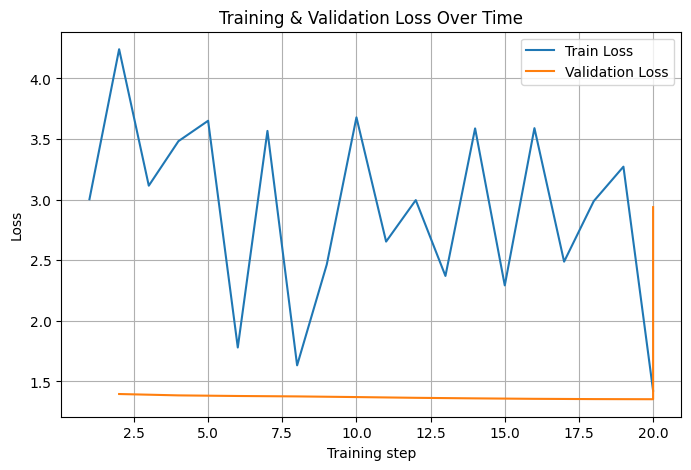

In [8]:
import matplotlib.pyplot as plt

df_logs = get_training_log_df(trainer)

train_loss = df_logs[df_logs["loss"].notna()][["step", "loss"]]
eval_loss = df_logs[df_logs["eval_loss"].notna()][["step", "eval_loss"]]

plt.figure(figsize=(8, 5))
plt.plot(train_loss["step"], train_loss["loss"], label="Train Loss")
plt.plot(eval_loss["step"], eval_loss["eval_loss"], label="Validation Loss")
plt.xlabel("Training step")
plt.ylabel("Loss")
plt.title("Training & Validation Loss Over Time")
plt.legend()
plt.grid(True)
plt.show()

## Download Fine-Tuned Model to Drive

Run the cell below if you want to download the entire `models/cheatsheet_model/`
directory to Google Drive for backup.

I had issues with my system memory when I tried saving it locally.

In [9]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [10]:
print("Local model exists?", os.path.exists("models/cheatsheet_model"))
!ls -la models/cheatsheet_model

# If it exists, then copy
if os.path.exists("models/cheatsheet_model"):
    from google.colab import drive
    drive.mount('/content/gdrive')
    !mkdir -p "/content/gdrive/MyDrive/CS372FinalProject/models"
    !cp -rv models/cheatsheet_model "/content/gdrive/MyDrive/CS372FinalProject/models/"
    print("Model saved to Drive!")
else:
    print("ERROR: Model doesn't exist locally!")

Local model exists? True
total 970348
drwxr-xr-x 5 root root      4096 Dec  9 04:47 .
drwxr-xr-x 3 root root      4096 Dec  9 02:06 ..
drwxr-xr-x 2 root root      4096 Dec  9 04:46 checkpoint-18
drwxr-xr-x 2 root root      4096 Dec  9 04:47 checkpoint-20
-rw-r--r-- 1 root root      1509 Dec  9 04:47 config.json
-rw-r--r-- 1 root root       152 Dec  9 04:47 generation_config.json
-rw-r--r-- 1 root root 990345064 Dec  9 04:47 model.safetensors
drwxr-xr-x 6 root root      4096 Dec  9 04:39 runs
-rw-r--r-- 1 root root      2543 Dec  9 04:47 special_tokens_map.json
-rw-r--r-- 1 root root    791656 Dec  9 04:47 spiece.model
-rw-r--r-- 1 root root     20830 Dec  9 04:47 tokenizer_config.json
-rw-r--r-- 1 root root   2422332 Dec  9 04:47 tokenizer.json
-rw-r--r-- 1 root root      6033 Dec  9 04:47 training_args.bin
Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).
'models/cheatsheet_model/runs/Dec09_02-06-00_3ea99

In [11]:
import os

print("Checking Drive contents...")
print("\nDoes CS372FinalProject exist?", os.path.exists("/content/gdrive/MyDrive/CS372FinalProject"))
print("Does models dir exist?", os.path.exists("/content/gdrive/MyDrive/CS372FinalProject/models"))

# List what's actually there
if os.path.exists("/content/gdrive/MyDrive/CS372FinalProject"):
    print("\nContents of CS372FinalProject:")
    !ls -la "/content/gdrive/MyDrive/CS372FinalProject"

if os.path.exists("/content/gdrive/MyDrive/CS372FinalProject/models"):
    print("\nContents of models dir:")
    !ls -la "/content/gdrive/MyDrive/CS372FinalProject/models"

Checking Drive contents...

Does CS372FinalProject exist? True
Does models dir exist? True

Contents of CS372FinalProject:
total 4
drwx------ 3 root root 4096 Dec  8 22:12 models

Contents of models dir:
total 4
drwx------ 10 root root 4096 Dec  9 04:47 cheatsheet_model
